# Landmark-Retrival - DELF


## Sample code for 2 images at a time

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

import glob
import os
from itertools import accumulate

np.random.seed(10)

In [94]:
# IMAGE_1_URL = 'https://images.unsplash.com/photo-1522184808165-a39a75502037?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=9058a9f269234b4d7b6dc7bd7066d7e8&auto=format&fit=crop&w=1350&q=80'
# IMAGE_2_URL = 'https://images.unsplash.com/photo-1479660656269-197ebb83b540?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=88b85498e4c076fce0ed0c086543afb6&auto=format&fit=crop&w=1952&q=80'

IMAGE_1_URL = 'C:/Users/Anuraag/Desktop/image1.jpg'
IMAGE_2_URL = 'C:/Users/Anuraag/Desktop/image4.jpg'

In [95]:
# The names that will be used for the resized local images.

IMAGE_1_JPG = 'image_1.jpg'
IMAGE_2_JPG = 'image_2.jpg'

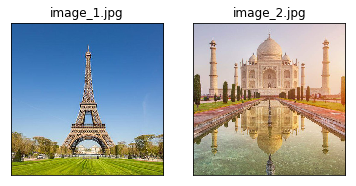

In [96]:
#@title The images that will be processed by DELF
def download_and_resize_image(url, filename, new_width=96, new_height=96):
    if 'http' in url:
        response = urlopen(url)
        image_data = response.read()
        pil_image = Image.open(BytesIO(image_data))
    else:
        pil_image = Image.open(url)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(filename, format='JPEG', quality=90)

download_and_resize_image(IMAGE_1_URL, IMAGE_1_JPG)
download_and_resize_image(IMAGE_2_URL, IMAGE_2_JPG)

def show_images(image_path_list):
    plt.figure()
    for i, image_path in enumerate(image_path_list):
        plt.subplot(1, len(image_path_list), i+1)
        plt.imshow(np.asarray(Image.open(image_path)))
        plt.title(image_path)
        plt.grid(False)
        plt.yticks([])
        plt.xticks([])
    plt.show()

show_images([IMAGE_1_JPG, IMAGE_2_JPG])

In [9]:
def image_input_fn(image_files):
    filename_queue = tf.train.string_input_producer(
        image_files, shuffle=False)
    reader = tf.WholeFileReader()
    _, value = reader.read(filename_queue)
    image_tf = tf.image.decode_jpeg(value, channels=3)
    return tf.image.convert_image_dtype(image_tf, tf.float32)

In [98]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn([IMAGE_1_JPG, IMAGE_2_JPG])

with tf.train.MonitoredSession() as sess:
    results_dict = {}  # Stores the locations and their descriptors for each image
    for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        results_dict[image_path] = sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

Extracting locations and descriptors from image_1.jpg
Extracting locations and descriptors from image_2.jpg


Loaded image 1's 362 features
Loaded image 2's 706 features


C:\Users\Anuraag\Anaconda2\envs\py36\lib\site-packages\skimage\transform\_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
C:\Users\Anuraag\Anaconda2\envs\py36\lib\site-packages\skimage\transform\_geometric.py:684: RuntimeWarning: invalid value encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
C:\Users\Anuraag\Anaconda2\envs\py36\lib\site-packages\skimage\measure\fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


Found 17 inliers


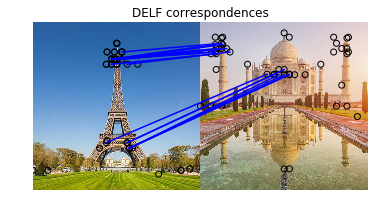

<Figure size 1296x1728 with 0 Axes>

In [99]:
#@title TensorFlow is not needed for this post-processing and visualization
def match_images(results_dict, image_1_path, image_2_path):
    distance_threshold = 0.8

    # Read features.
    locations_1, descriptors_1 = results_dict[image_1_path]
    num_features_1 = locations_1.shape[0]
    print("Loaded image 1's %d features" % num_features_1)
    locations_2, descriptors_2 = results_dict[image_2_path]
    num_features_2 = locations_2.shape[0]
    print("Loaded image 2's %d features" % num_features_2)

    # Find nearest-neighbor matches using a KD tree.
    d1_tree = cKDTree(descriptors_1)
    _, indices = d1_tree.query(
        descriptors_2, distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
    locations_2_to_use = np.array([
        locations_2[i,]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])
    locations_1_to_use = np.array([
        locations_1[indices[i],]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])

  # Perform geometric verification using RANSAC.
    _, inliers = ransac(
        (locations_1_to_use, locations_2_to_use),
        AffineTransform,
        min_samples=3,
        residual_threshold=20,
        max_trials=1000)
    # the number of inliers as the score for retrieved images.
    print('Found %d inliers' % sum(inliers))

    # Visualize correspondences.
    _, ax = plt.subplots()
    img_1 = mpimg.imread(image_1_path)
    img_2 = mpimg.imread(image_2_path)
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
        ax,
        img_1,
        img_2,
        locations_1_to_use,
        locations_2_to_use,
        np.column_stack((inlier_idxs, inlier_idxs)),
        matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    plt.figure(figsize=(18,24))
    plt.show()

match_images(results_dict, IMAGE_1_JPG, IMAGE_2_JPG)


## Code for all images if Resizing of image required

In [6]:
import pandas as pd
from pandas import Series,DataFrame
pred=pd.read_csv('C:/Users/Anuraag/Downloads/predictions.csv') #csv file containing predictions for test images from neural network

In [ ]:
for zoro in range(0,len(pred.index)):
    class_folder = str(pred['landmarks'][zoro])
    test_image_id = str(pred['id'][zoro])
    def resize_image(srcfile, destfile, new_width=96, new_height=96):
        pil_image = Image.open(srcfile)
        pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
        pil_image_rgb = pil_image.convert('RGB')
        pil_image_rgb.save(destfile, format='JPEG', quality=90)
        return destfile
    def resize_images_folder(srcfolder, destfolder='C:/Users/Anuraag/Desktop/Data/train_images_model_resize/%s'%(class_folder), new_width=96, new_height=96):
        os.makedirs(destfolder,exist_ok=True)
        for srcfile in glob.iglob(os.path.join('C:/Users/Anuraag/Desktop/Data/train_images_model/%s'%(class_folder), '*.[Jj][Pp][Gg]')):
            src_basename = os.path.basename(srcfile)
            destfile=os.path.join(destfolder,src_basename)
            resize_image(srcfile, destfile, new_width, new_height)
        return destfolder
###########################################################################################################################
    def get_resized_db_image_paths(destfolder='C:/Users/Anuraag/Desktop/Data/train_images_model_resize/%s'%(class_folder)):
        return sorted(list(glob.iglob(os.path.join(destfolder, '*.[Jj][Pp][Gg]'))))
    resize_images_folder('C:/Users/Anuraag/Desktop/Data/train_images_model/%s'%(class_folder))
    db_images = get_resized_db_image_paths() ## list of image paths
    
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.FATAL)

    m = hub.Module('https://tfhub.dev/google/delf/1')

    # The module operates on a single image at a time, so define a placeholder to
    # feed an arbitrary image in.
    image_placeholder = tf.placeholder(
        tf.float32, shape=(None, None, 3), name='input_image')

    module_inputs = {
        'image': image_placeholder,
        'score_threshold': 100.0,
        'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
        'max_feature_num': 1000,
    }

    module_outputs = m(module_inputs, as_dict=True)

    image_tf = image_input_fn(db_images) ##  training images path list inputted

    with tf.train.MonitoredSession() as sess:
        results_dict = {}  # Stores the locations and their descriptors for each image
        for image_path in db_images:
            image = sess.run(image_tf)
            print('Extracting locations and descriptors from %s' % image_path)
            results_dict[image_path] = sess.run(
                [module_outputs['locations'], module_outputs['descriptors']],
                feed_dict={image_placeholder: image})
  #########################################################################################################################          
    def compute_locations_and_descriptors(image_path):
        tf.reset_default_graph()
        tf.logging.set_verbosity(tf.logging.FATAL)

        m = hub.Module('https://tfhub.dev/google/delf/1')

        # The module operates on a single image at a time, so define a placeholder to
        # feed an arbitrary image in.
        image_placeholder = tf.placeholder(
            tf.float32, shape=(None, None, 3), name='input_image')

        module_inputs = {
            'image': image_placeholder,
            'score_threshold': 100.0,
            'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
            'max_feature_num': 1000,
        }

        module_outputs = m(module_inputs, as_dict=True)

        image_tf = image_input_fn([image_path])

        with tf.train.MonitoredSession() as sess:
            image = sess.run(image_tf)
            print('Extracting locations and descriptors from %s' % image_path)
            return sess.run(
                [module_outputs['locations'], module_outputs['descriptors']],
                feed_dict={image_placeholder: image})
        
###############################################################################################################################
    locations_agg = np.concatenate([results_dict[img][0] for img in db_images])
    descriptors_agg = np.concatenate([results_dict[img][1] for img in db_images])
    accumulated_indexes_boundaries = list(accumulate([results_dict[img][0].shape[0] for img in db_images]))
    
###############################################################################################################################
    d_tree = cKDTree(descriptors_agg) # build the KD tree
    
###############################################################################################################################
    query_image = 'C:/Users/Anuraag/Desktop/Data/test_images/%s.jpg'%(test_image_id)
    def preprocess_query_image(imagepath):
        '''
        Resize the query image and return the resized image path.
        '''
        query_temp_folder_name = 'query_temp_folder'
        query_temp_folder = os.path.join(os.path.dirname(query_image), query_temp_folder_name)
        os.makedirs(query_temp_folder,exist_ok=True)
        query_basename = os.path.basename(query_image)
        destfile=os.path.join(query_temp_folder,query_basename)
        resized_image = resize_image(query_image, destfile)
        return resized_image

    resized_image = preprocess_query_image(query_image)
    
###############################################################################################################################
    query_image_locations, query_image_descriptors = compute_locations_and_descriptors(resized_image)
    
###############################################################################################################################
    distance_threshold = 0.8
    # K nearest neighbors
    K = 10
    distances, indices = d_tree.query(
        query_image_descriptors, distance_upper_bound=distance_threshold, k = K, n_jobs=-1)

    # Find the list of unique accumulated/aggregated indexes
    unique_indices = np.array(list(set(indices.flatten())))

    unique_indices.sort()
    if unique_indices[-1] == descriptors_agg.shape[0]:
        unique_indices = unique_indices[:-1]
        
###############################################################################################################################
    unique_image_indexes = np.array(
        list(set([np.argmax([np.array(accumulated_indexes_boundaries)>index]) 
                  for index in unique_indices])))
    unique_image_indexes
    
###############################################################################################################################
    def image_index_2_accumulated_indexes(index, accumulated_indexes_boundaries):
        '''
        Image index to accumulated/aggregated locations/descriptors pair indexes.
        '''
        if index > len(accumulated_indexes_boundaries) - 1:
            return None
        accumulated_index_start = None
        accumulated_index_end = None
        if index == 0:
            accumulated_index_start = 0
            accumulated_index_end = accumulated_indexes_boundaries[index]
        else:
            accumulated_index_start = accumulated_indexes_boundaries[index-1]
            accumulated_index_end = accumulated_indexes_boundaries[index]
        return np.arange(accumulated_index_start,accumulated_index_end)
    
###############################################################################################################################
    def get_locations_2_use(image_db_index, k_nearest_indices, accumulated_indexes_boundaries):
        '''
        Get a pair of locations to use, the query image to the database image with given index.
        Return: a tuple of 2 numpy arrays, the locations pair.
        '''
        image_accumulated_indexes = image_index_2_accumulated_indexes(image_db_index, accumulated_indexes_boundaries)
        locations_2_use_query = []
        locations_2_use_db = []
        for i, row in enumerate(k_nearest_indices):
            for acc_index in row:
                if acc_index in image_accumulated_indexes:
                    locations_2_use_query.append(query_image_locations[i])
                    locations_2_use_db.append(locations_agg[acc_index])
                    break
        return np.array(locations_2_use_query), np.array(locations_2_use_db)
    
###############################################################################################################################
    # Array to keep track of all candidates in database.
    inliers_counts = []
    # Read the resized query image for plotting.
    img_1 = mpimg.imread(resized_image)
    for index in unique_image_indexes:
        locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
        # Perform geometric verification using RANSAC.
        _, inliers = ransac(
            (locations_2_use_db, locations_2_use_query), # source and destination coordinates
            AffineTransform,
            min_samples=3,
            residual_threshold=20,
            max_trials=1000)
        # If no inlier is found for a database candidate image, we continue on to the next one.
        if inliers is None or len(inliers) == 0:
            continue
        # the number of inliers as the score for retrieved images.
        inliers_counts.append({"index": index, "inliers": sum(inliers)})
        print('Found inliers for image {} -> {}'.format(index, sum(inliers)))
        # Visualize correspondences.
        _, ax = plt.subplots()
        img_2 = mpimg.imread(db_images[index])
        inlier_idxs = np.nonzero(inliers)[0]
        plot_matches(
            ax,
            img_1,
            img_2,
            locations_2_use_db,
            locations_2_use_query,
            np.column_stack((inlier_idxs, inlier_idxs)),
            matches_color='b')
        ax.axis('off')
        ax.set_title('DELF correspondences')
        plt.show()
        
    ###############################################################################################################################
        inliers_list=[]
        for inl in inliers_counts:
            inliers_list.append(inl['inliers'])
        from statistics import mean
        if len(inliers_list)>0:
            mean_features=mean(inliers_list)
        else:
            mean_features=0
        print(inliers_counts)
        print(inliers_list)
    
        #deciding landmark or not based on threshold
        if mean_features<5:
            predictions['Landmark_Yes/No'][zoro]=0
        else:
            predictions['Landmark_Yes/No'][zoro]=1

## Code for all images if no Resize required

In [21]:
import pandas as pd
from pandas import Series,DataFrame
predictions=pd.read_csv('C:/Users/Anuraag/Downloads/junk_predictions.csv')

In [26]:
import numpy as np 
import pandas as pd 
import sys, requests, shutil, os
# from urllib import request, error
# Input data files are available in the "../Data/" directory.
print(os.listdir("C:/Users/Anuraag/Downloads/Data"))
data=pd.read_csv('C:/Users/Anuraag/Downloads/Data/train.csv')
test_data = pd.read_csv('C:/Users/Anuraag/Downloads/Data/test.csv')
data.head(5)

['test.csv', 'train.csv']


,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


In [23]:
import re
predictions['landmarks']=predictions['landmarks'].map(lambda x: re.findall("(.+)\s",x)[0])

In [27]:
data_sample = data[data['landmark_id'].isin(predictions['landmarks'])]

In [28]:
#https://www.kaggle.com/lyakaap/fast-resized-image-download-python-3
import re
TARGET_SIZE = 96


'''change URLs to resize images to target size'''
def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)

    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)
    
    df = df[df.url.apply(lambda x: len(x.split('/'))>1)]
    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df

data_sample_resize = overwrite_urls(data_sample)
print ('1. URLs overwritten')

1. URLs overwritten


In [31]:
'''Split into train and validation set'''
data_valid = pd.DataFrame(columns = ['id','url','landmark_id'])
data_train = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_validation = 0.9
import random
random.seed(42)
for landmark_id in set(data_sample_resize['landmark_id']):
    n=1
    t = data_sample_resize[(data_sample_resize.landmark_id == landmark_id)]
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])
        i += 1
        
    valid = random.sample(r,int(percent_validation*len(r)))
#     if len(r) > 1:
#         valid = random.sample(r, 1)
#     else:
#         valid = []
    train = list(set(r) - set(valid)) 
    data_v = data_sample_resize[data_sample_resize.id.isin(valid)]
    data_t = data_sample_resize[data_sample_resize.id.isin(train)]
    data_valid = data_valid.append(data_v)
    data_train = data_train.append(data_t)
    n+=1

print ('3. train and validation set created')

3. train and validation set created


In [41]:
def fetch_image(path,folder):
    url=path
    response=requests.get(url, stream=True)
    with open('C:/Users/Anuraag/Downloads/Data/' + folder + '/image.jpg', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    
    
'''TRAIN SET - fetch images for the resized URLs and save in the already created directory train_images_resize'''
i=0
for link in data_train['url']:              #looping over links to get images
    if os.path.exists('C:/Users/Anuraag/Downloads/Data/train_images_model/'+str(data_train['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'train_images_model')
    os.rename('C:/Users/Anuraag/Downloads/Data/train_images_model/image.jpg','C:/Users/Anuraag/Downloads/Data/train_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')
    i+=1
#     if(i==100):   #uncomment to test in your machine
#         break
print('4. train images fetched')

4. train images fetched


In [100]:
##create folders for landmark IDs
import pandas as pd
import os
import shutil
from shutil import copyfile
train_data = data_train
import urllib

temp = pd.DataFrame(data_train.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

def createfolders(dataset,folder):
    i = 0
    while i < len(dataset):
        landmark = str(dataset.landmark_id.iloc[i])
        path = 'C:/Users/Anuraag/Downloads/Data/' + folder + '/'+ landmark
        if not os.path.exists(path):
            os.makedirs(path)
        i+=1
createfolders(temp,'train_images_model')

print ('folders created')

rootdirpics = r'C:/Users/Anuraag/Downloads/Data/train_images_model/'
rootdirfolders = r'C:/Users/Anuraag/Downloads/Data/train_images_model/'

def transformdata(data,path1, path2):

    n = 1
    for landmark_id in set(data['landmark_id']):
        t = data[(data.landmark_id == landmark_id)]
        i = 1
        r =[]
        while i <= len(t.id):
            it = i - 1
            r.append(t.id.iloc[it])
            i += 1
        for files in os.listdir(rootdirpics):    # loop through startfolders
#             if len(files) < 15:
#                 break
            inpath = path1 + files
            folder = str(landmark_id)
            outpath = path2 + folder  
            if ((files.split('.')[0] in r) & (os.path.getsize(inpath) >1000)):
#                 print('move')
                shutil.move(inpath, outpath)
            elif ((files.split('.')[0] in r) & (os.path.getsize(inpath) <= 1000)):
                os.remove(inpath)
        n+=1

transformdata(train_data,rootdirpics, rootdirfolders)

folders created


In [114]:
predictions['id']=predictions.id.astype(str)

In [115]:
test_data['id']=test_data.id.astype(str)

In [117]:
test_data_junk = predictions.merge(test_data,on=['id'],how='left')

In [125]:
data_test_resize = overwrite_urls(test_data_junk)
print ('1. URLs overwritten')
len(data_test_resize.id)

1. URLs overwritten


C:\Users\Anuraag\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


969

In [126]:


def fetch_image(path):
    url=path
    if url != 'None':
        response=requests.get(url, stream=True)
        with open('C:/Users/Anuraag/Downloads/Data/test_images/image.jpg', 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
        del response
    
i=0

for link in test_data_junk['url']:              #looping over links to get images
    if link != 'None':
        if os.path.exists('C:/Users/Anuraag/Downloads/Data/test_images/'+str(test_data['id'].iloc[i])+'.jpg'):
            i+=1
            continue
        fetch_image(link)
        n = 'C:/Users/Anuraag/Downloads/Data/test_images/'+str(test_data['id'].iloc[i])+ '.jpg'
        os.rename('C:/Users/Anuraag/Downloads/Data/test_images/image.jpg',n)
        if os.path.getsize(n) < 1000:
            os.remove(n)
            
        i+=1
#         if(i==1000):   #uncomment to test in your machine
#             break
print('4. Test images fetched')

4. Test images fetched


In [127]:
def resize_image(srcfile, destfile, new_width=96, new_height=96):
    pil_image = Image.open(srcfile)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(destfile, format='JPEG', quality=90)
    return destfile
def resize_images_folder(srcfolder, destfolder='C:/Users/Anuraag/Downloads/Data/test_images', new_width=96, new_height=96):
    os.makedirs(destfolder,exist_ok=True)
    for srcfile in glob.iglob(os.path.join('C:/Users/Anuraag/Downloads/Data/test_images_model', '*.[Jj][Pp][Gg]')):
        src_basename = os.path.basename(srcfile)
        destfile=os.path.join(destfolder,src_basename)
        resize_image(srcfile, destfile, new_width, new_height)
    return destfolder

resize_images_folder('C:/Users/Anuraag/Downloads/Data/test_images_model')

'C:/Users/Anuraag/Downloads/Data/test_images'

In [160]:
predictions['Landmark_Yes/No']=Series([])

In [162]:
predictions.head()

,id,landmarks,Unnamed: 2,Landmark_Yes/No
0,d86fb718915236c2,1963,NaN,NaN
1,86662e5e6ac54260,1403,NaN,NaN
2,8c0a0a30d66adbe6,2503,NaN,NaN
3,cf9d96b21e1a044b,2501,NaN,NaN
4,b11e1008d3a682ed,1422,NaN,NaN


In [ ]:
for zoro in range(0,len(predictions.index)):
    class_folder = str(predictions['landmarks'][zoro])
    test_image_id = str(predictions['id'][zoro])
    def get_resized_db_image_paths(destfolder='C:/Users/Anuraag/Downloads/Data/train_images_model/%s'%(class_folder)):
        return sorted(list(glob.iglob(os.path.join(destfolder, '*.[Jj][Pp][Gg]'))))
    db_images = get_resized_db_image_paths()
    
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.FATAL)

    m = hub.Module('https://tfhub.dev/google/delf/1')

    # The module operates on a single image at a time, so define a placeholder to
    # feed an arbitrary image in.
    image_placeholder = tf.placeholder(
        tf.float32, shape=(None, None, 3), name='input_image')

    module_inputs = {
        'image': image_placeholder,
        'score_threshold': 100.0,
        'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
        'max_feature_num': 1000,
    }

    module_outputs = m(module_inputs, as_dict=True)

    image_tf = image_input_fn(db_images) ##  training images path list inputted

    with tf.train.MonitoredSession() as sess:
        results_dict = {}  # Stores the locations and their descriptors for each image
        for image_path in db_images:
            image = sess.run(image_tf)
#             print('Extracting locations and descriptors from %s' % image_path)
            results_dict[image_path] = sess.run(
                [module_outputs['locations'], module_outputs['descriptors']],
                feed_dict={image_placeholder: image})
  #########################################################################################################################          
    def compute_locations_and_descriptors(image_path):
        tf.reset_default_graph()
        tf.logging.set_verbosity(tf.logging.FATAL)

        m = hub.Module('https://tfhub.dev/google/delf/1')

        # The module operates on a single image at a time, so define a placeholder to
        # feed an arbitrary image in.
        image_placeholder = tf.placeholder(
            tf.float32, shape=(None, None, 3), name='input_image')

        module_inputs = {
            'image': image_placeholder,
            'score_threshold': 100.0,
            'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
            'max_feature_num': 1000,
        }

        module_outputs = m(module_inputs, as_dict=True)

        image_tf = image_input_fn([image_path])

        with tf.train.MonitoredSession() as sess:
            image = sess.run(image_tf)
            print('Extracting locations and descriptors from %s' % image_path)
            return sess.run(
                [module_outputs['locations'], module_outputs['descriptors']],
                feed_dict={image_placeholder: image})
        
###############################################################################################################################
    locations_agg = np.concatenate([results_dict[img][0] for img in db_images])
    descriptors_agg = np.concatenate([results_dict[img][1] for img in db_images])
    accumulated_indexes_boundaries = list(accumulate([results_dict[img][0].shape[0] for img in db_images]))
    
###############################################################################################################################
    d_tree = cKDTree(descriptors_agg) # build the KD tree
    
###############################################################################################################################
    query_image = 'C:/Users/Anuraag/Downloads/Data/test_images/%s.jpg'%(test_image_id)
    def preprocess_query_image(imagepath):
        '''
        Resize the query image and return the resized image path.
        '''
        query_temp_folder_name = 'query_temp_folder'
        query_temp_folder = os.path.join(os.path.dirname(query_image), query_temp_folder_name)
        os.makedirs(query_temp_folder,exist_ok=True)
        query_basename = os.path.basename(query_image)
        destfile=os.path.join(query_temp_folder,query_basename)
        resized_image = resize_image(query_image, destfile)
        return resized_image

    resized_image = preprocess_query_image(query_image)
    
###############################################################################################################################
    query_image_locations, query_image_descriptors = compute_locations_and_descriptors(resized_image)
    
###############################################################################################################################
    distance_threshold = 0.8
    # K nearest neighbors
    K = 10
    distances, indices = d_tree.query(
        query_image_descriptors, distance_upper_bound=distance_threshold, k = K, n_jobs=-1)

    # Find the list of unique accumulated/aggregated indexes
    unique_indices = np.array(list(set(indices.flatten())))

    unique_indices.sort()
    if unique_indices[-1] == descriptors_agg.shape[0]:
        unique_indices = unique_indices[:-1]
        
###############################################################################################################################
    unique_image_indexes = np.array(
        list(set([np.argmax([np.array(accumulated_indexes_boundaries)>index]) 
                  for index in unique_indices])))
    unique_image_indexes
    
###############################################################################################################################
    def image_index_2_accumulated_indexes(index, accumulated_indexes_boundaries):
        '''
        Image index to accumulated/aggregated locations/descriptors pair indexes.
        '''
        if index > len(accumulated_indexes_boundaries) - 1:
            return None
        accumulated_index_start = None
        accumulated_index_end = None
        if index == 0:
            accumulated_index_start = 0
            accumulated_index_end = accumulated_indexes_boundaries[index]
        else:
            accumulated_index_start = accumulated_indexes_boundaries[index-1]
            accumulated_index_end = accumulated_indexes_boundaries[index]
        return np.arange(accumulated_index_start,accumulated_index_end)
    
###############################################################################################################################
    def get_locations_2_use(image_db_index, k_nearest_indices, accumulated_indexes_boundaries):
        '''
        Get a pair of locations to use, the query image to the database image with given index.
        Return: a tuple of 2 numpy arrays, the locations pair.
        '''
        image_accumulated_indexes = image_index_2_accumulated_indexes(image_db_index, accumulated_indexes_boundaries)
        locations_2_use_query = []
        locations_2_use_db = []
        for i, row in enumerate(k_nearest_indices):
            for acc_index in row:
                if acc_index in image_accumulated_indexes:
                    locations_2_use_query.append(query_image_locations[i])
                    locations_2_use_db.append(locations_agg[acc_index])
                    break
        return np.array(locations_2_use_query), np.array(locations_2_use_db)
    
###############################################################################################################################
    # Array to keep track of all candidates in database.
    inliers_counts = []
    # Read the resized query image for plotting.
    img_1 = mpimg.imread(resized_image)
    for index in unique_image_indexes:
        locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
        # Perform geometric verification using RANSAC.
        _, inliers = ransac(
            (locations_2_use_db, locations_2_use_query), # source and destination coordinates
            AffineTransform,
            min_samples=3,
            residual_threshold=20,
            max_trials=1000)
        # If no inlier is found for a database candidate image, we continue on to the next one.
        if inliers is None or len(inliers) == 0:
            continue
        # the number of inliers as the score for retrieved images.
        inliers_counts.append({"index": index, "inliers": sum(inliers)})
#         print('Found inliers for image {} -> {}'.format(index, sum(inliers)))
#         # Visualize correspondences.
#         _, ax = plt.subplots()
#         img_2 = mpimg.imread(db_images[index])
#         inlier_idxs = np.nonzero(inliers)[0]
#         plot_matches(
#             ax,
#             img_1,
#             img_2,
#             locations_2_use_db,
#             locations_2_use_query,
#             np.column_stack((inlier_idxs, inlier_idxs)),
#             matches_color='b')
#         ax.axis('off')
#         ax.set_title('DELF correspondences')
#         plt.show()
        
###############################################################################################################################
    inliers_list=[]
    for inl in inliers_counts:
        inliers_list.append(inl['inliers'])
    from statistics import mean
    if len(inliers_list)>0:
        mean_features=mean(inliers_list)
    else:
        mean_features=0
    print(inliers_counts)
    print(inliers_list)
    
    #deciding landmark or not based on threshold
    if mean_features<5:
        predictions['Landmark_Yes/No'][zoro]=0
    else:
        predictions['Landmark_Yes/No'][zoro]=1
        
    